
✅ Updated Movie Type Output:
        Movie_Type  count
0            Drama  34007
1           Comedy  16349
2           Action  10234
3          Romance   9094
4           Horror   8798
5         Thriller   8744
6  Science Fiction   8141
7        Adventure   7155
8          Mystery   6948
9        Animation   6897

✅ Updated Actor Count Output:


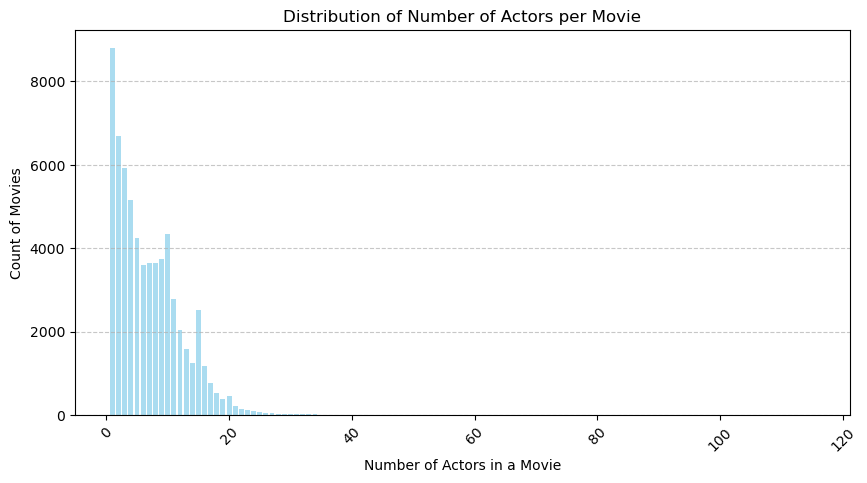

    Number of Actors  Movie Count
0                  1         8792
1                  2         6696
2                  3         5924
3                  4         5154
4                 10         4329
..               ...          ...
62                78            1
63                87            1
64                42            1
65                44            1
66               115            1

[67 rows x 2 columns]

✅ Actor Distribution for All Genders:


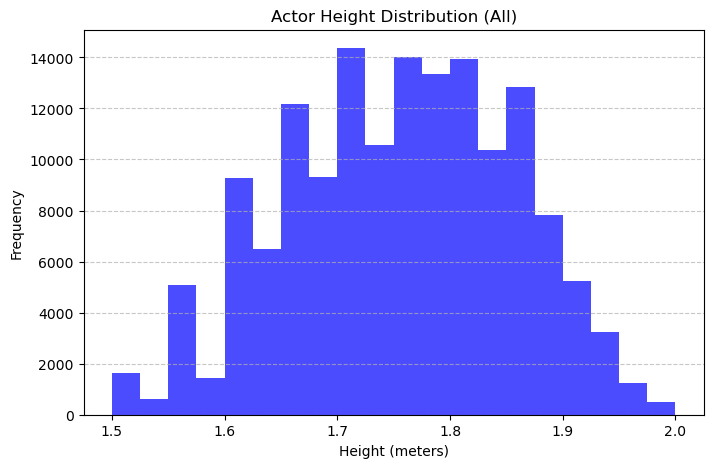


✅ Actor Distribution for Female Actors:


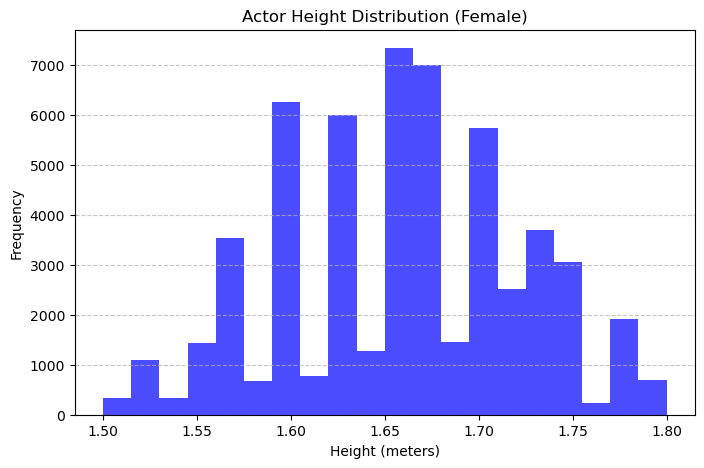

In [1]:
import os
import pandas as pd
import ast  # For safely parsing genre strings
import matplotlib.pyplot as plt

class MovieAnalyzer:
    DATA_DIR = "downloads"
    
    # Paths to the dataset files
    MOVIE_FILE = r"C:\Users\inesf\OneDrive\Ambiente de Trabalho\Mestrado\Advanced Programming for Data Science\movie.metadata.tsv"
    CHARACTER_FILE = r"C:\Users\inesf\OneDrive\Ambiente de Trabalho\Mestrado\Advanced Programming for Data Science\character.metadata.tsv"

    # Freebase genre ID to readable name mapping
    GENRE_MAPPING = {
        "/m/07s9rl0": "Drama",
        "/m/01z4y": "Comedy",
        "/m/02l7c8": "Action",
        "/m/01g6gs": "Romance",
        "/m/02kdv5l": "Horror",
        "/m/01jfsb": "Thriller",
        "/m/02hmvc": "Science Fiction",
        "/m/03q4nz": "Adventure",
        "/m/0lsxr": "Mystery",
        "/m/0219x_": "Animation"
    }

    def __init__(self):
        """Loads the movie and character datasets and merges them."""
        self.movies_df = self._load_movies()
        self.characters_df = self._load_characters()
        self.merged_df = self._merge_data()

    def _load_movies(self):
        """Loads movie metadata into a pandas DataFrame."""
        file_path = os.path.join(self.MOVIE_FILE)
        columns = [
            "wikipedia_movie_id", "freebase_movie_id", "movie_name", "release_date",
            "box_office", "runtime", "languages", "countries", "genres"
        ]
        return pd.read_csv(file_path, sep="\t", header=None, names=columns)

    def _load_characters(self):
        """Loads character metadata into a pandas DataFrame."""
        file_path = os.path.join(self.CHARACTER_FILE)
        columns = [
            "wikipedia_movie_id", "freebase_movie_id", "release_date", "character_name",
            "actor_dob", "actor_gender", "actor_height", "actor_ethnicity",
            "actor_name", "actor_age_at_release", "character_actor_map_id",
            "character_id", "actor_id"
        ]
        return pd.read_csv(file_path, sep="\t", header=None, names=columns)

    def _merge_data(self):
        """Merges movie and character datasets on 'wikipedia_movie_id'."""
        return pd.merge(self.characters_df, self.movies_df, on="wikipedia_movie_id", how="inner")

    def movie_type(self, N=10):
        """Returns the top N most common movie genres."""
        if not isinstance(N, int):
            raise ValueError("N must be an integer")

        # Parse genre column safely
        self.movies_df["genres"] = self.movies_df["genres"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("{") else []
        )

        # Extract and count genres
        genre_counts = pd.Series(
            [self.GENRE_MAPPING.get(genre, genre) for sublist in self.movies_df["genres"] for genre in sublist]
        ).value_counts()

        return genre_counts.head(N).reset_index().rename(columns={"index": "Movie_Type", 0: "Count"})

    def actor_count(self, plot=False):
        """Returns a histogram of the number of actors per movie.
           If plot=True, displays a histogram of the actor count distribution.
        """
        valid_actors = self.merged_df.dropna(subset=["actor_name"])  # Drop NaN actor names
        actor_counts = valid_actors.groupby("wikipedia_movie_id")["actor_name"].count().value_counts().reset_index()
        actor_counts.columns = ["Number of Actors", "Movie Count"]
        
        # Sort in descending order
        actor_counts = actor_counts.sort_values(by="Movie Count", ascending=False)

        if plot:
            plt.figure(figsize=(10, 5))
            plt.bar(actor_counts["Number of Actors"], actor_counts["Movie Count"], color="skyblue", alpha=0.7)
            plt.xlabel("Number of Actors in a Movie")
            plt.ylabel("Count of Movies")
            plt.title("Distribution of Number of Actors per Movie")
            plt.xticks(rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

        return actor_counts

    def actor_distributions(self, gender="All", min_height=0.5, max_height=2.5, plot=False):
        """Returns filtered actors by height and gender, with an optional plot.
        
        - gender: "All", "Female", "Male", or other valid dataset values
        - min_height, max_height: Filter range for actor heights
        - plot: If True, displays a histogram of actor height distribution
        """
        if not isinstance(gender, str) or not isinstance(min_height, (int, float)) or not isinstance(max_height, (int, float)):
            raise ValueError("Invalid data type for arguments")

        # Ensure height is numeric
        self.merged_df["actor_height"] = pd.to_numeric(self.merged_df["actor_height"], errors="coerce")

        # Ensure gender is standardized (some datasets use 'F'/'M' instead of 'Female'/'Male')
        self.merged_df["actor_gender"] = self.merged_df["actor_gender"].replace({"F": "Female", "M": "Male"})

        # Filter by height range
        filtered_df = self.merged_df[
            (self.merged_df["actor_height"] >= min_height) & (self.merged_df["actor_height"] <= max_height)
        ]

        # Allow filtering by specific gender, but support "All"
        if gender != "All":
            valid_genders = self.merged_df["actor_gender"].dropna().unique()  # Get all non-null unique gender values
            if gender not in valid_genders:
                raise ValueError(f"Invalid gender. Choose from: {list(valid_genders) + ['All']}")
            filtered_df = filtered_df[filtered_df["actor_gender"] == gender]

        # If no matching data, show warning
        if filtered_df.empty:
            print(f"⚠️ No actors found matching: Gender={gender}, Height between {min_height}m and {max_height}m")

        # Generate plot if requested
        if plot and not filtered_df.empty:
            plt.figure(figsize=(8, 5))
            plt.hist(filtered_df["actor_height"].dropna(), bins=20, color="blue", alpha=0.7)
            plt.xlabel("Height (meters)")
            plt.ylabel("Frequency")
            plt.title(f"Actor Height Distribution ({gender})")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()

        return filtered_df


# Initialize and test the class
if __name__ == "__main__":
    analyzer = MovieAnalyzer()
    
    print("\n✅ Updated Movie Type Output:")
    print(analyzer.movie_type(10))  # Should show readable genre names

    print("\n✅ Updated Actor Count Output:")
    print(analyzer.actor_count(plot=True))  # Now shows a histogram!

    print("\n✅ Actor Distribution for All Genders:")
    analyzer.actor_distributions(gender="All", min_height=1.5, max_height=2.0, plot=True)

    print("\n✅ Actor Distribution for Female Actors:")
    analyzer.actor_distributions(gender="Female", min_height=1.5, max_height=1.8, plot=True)
